In [2]:
import re, nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
#from sklearn.externals import joblib
import joblib

In [3]:
def normalizer(tweet): #### Cleaning Tweets
    soup = BeautifulSoup(tweet, 'lxml')   # removing HTML encoding such as ‘&amp’,’&quot’
    souped = soup.get_text()
    only_words = re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\\\S+)"," ", souped) # removing @mentions, hashtags, urls.

    """
    For more info on regular expressions visit -
    https://docs.python.org/3/library/re.html
    https://www.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html
    """

    tokens = nltk.word_tokenize(only_words)
    removed_letters = [word for word in tokens if len(word)>2] # removing words with length less than or equal to 2
    lower_case = [l.lower() for l in removed_letters]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [4]:
def Cross_validation(data, targets, tfidf, clf_cv, model_name): #### Performs cross-validation on SVC

    kf = KFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
    scores=[]
    data_train_list = []
    targets_train_list = []
    data_test_list = []
    targets_test_list = []
    iteration = 0
    print("Performing cross-validation for {}...".format(model_name))
    for train_index, test_index in kf.split(data):
        iteration += 1
        print("Iteration ", iteration)
        data_train_cv, targets_train_cv = data[train_index], targets[train_index]
        data_test_cv, targets_test_cv = data[test_index], targets[test_index]
        data_train_list.append(data_train_cv) # appending training data for each iteration
        data_test_list.append(data_test_cv) # appending test data for each iteration
        targets_train_list.append(targets_train_cv) # appending training targets for each iteration
        targets_test_list.append(targets_test_cv) # appending test targets for each iteration
        tfidf.fit(data_train_cv) # learning vocabulary of training set
        data_train_tfidf_cv = tfidf.transform(data_train_cv)
        print("Shape of training data: ", data_train_tfidf_cv.shape)
        data_test_tfidf_cv = tfidf.transform(data_test_cv)
        print("Shape of test data: ", data_test_tfidf_cv.shape)
        clf_cv.fit(data_train_tfidf_cv, targets_train_cv) # Fitting SVC
        score = clf_cv.score(data_test_tfidf_cv, targets_test_cv) # Calculating accuracy
        scores.append(score) # appending cross-validation accuracy for each iteration
    print("List of cross-validation accuracies for {}: ".format(model_name), scores)
    mean_accuracy = np.mean(scores)
    print("Mean cross-validation accuracy for {}: ".format(model_name), mean_accuracy)
    print("Best cross-validation accuracy for {}: ".format(model_name), max(scores))
    max_acc_index = scores.index(max(scores)) # best cross-validation accuracy
    max_acc_data_train = data_train_list[max_acc_index] # training data corresponding to best cross-validation accuracy
    max_acc_data_test = data_test_list[max_acc_index] # test data corresponding to best cross-validation accuracy
    max_acc_targets_train = targets_train_list[max_acc_index] # training targets corresponding to best cross-validation accuracy
    max_acc_targets_test = targets_test_list[max_acc_index] # test targets corresponding to best cross-validation accuracy

    return mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test


In [5]:
def c_matrix(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, clf, model_name): #### Creates Confusion matrix for SVC
    tfidf.fit(max_acc_data_train)
    max_acc_data_train_tfidf = tfidf.transform(max_acc_data_train)
    max_acc_data_test_tfidf = tfidf.transform(max_acc_data_test)
    clf.fit(max_acc_data_train_tfidf, max_acc_targets_train) # Fitting SVC
    targets_pred = clf.predict(max_acc_data_test_tfidf) # Prediction on test data
    conf_mat = confusion_matrix(max_acc_targets_test, targets_pred)
    d={'Low': 'Low', 'High': 'High'}
    sentiment_df = targets.drop_duplicates().sort_values()
    sentiment_df= sentiment_df.apply(lambda x:d[x])
    sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=sentiment_df.values, yticklabels=sentiment_df.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix (Best Accuracy) - {}".format(model_name))
    plt.show()

In [6]:
def SVC_Save(data, targets, tfidf):
    tfidf.fit(data) # learn vocabulary of entire data
    data_tfidf = tfidf.transform(data)
    pd.DataFrame.from_dict(data=dict([word, i] for i, word in enumerate(tfidf.get_feature_names())), orient='index').to_csv('vocabulary_SVC.csv', header=False)
    print("Shape of tfidf matrix for saved SVC Model: ", data_tfidf.shape)
    clf = LinearSVC().fit(data_tfidf, targets)
    joblib.dump(clf, 'svc.sav')


In [7]:
def NBC_Save(data, targets, tfidf):
    tfidf.fit(data) # learn vocabulary of entire data
    data_tfidf = tfidf.transform(data)
    pd.DataFrame.from_dict(data=dict([word, i] for i, word in enumerate(tfidf.get_feature_names())), orient='index').to_csv('vocabulary_NBC.csv', header=False)
    print("Shape of tfidf matrix for saved NBC Model: ", data_tfidf.shape)
    clf = MultinomialNB(alpha=1.0).fit(data_tfidf, targets)
    joblib.dump(clf, 'nbc.sav')


In [8]:
def deployment():

#### Loading the saved model
    model = joblib.load('svc.sav')
    vocabulary_model = pd.read_csv('vocabulary_SVC.csv', header=None)
    vocabulary_model_dict = {}
    for i, word in enumerate(vocabulary_model[0]):
         vocabulary_model_dict[word] = i
    tfidf = TfidfVectorizer(sublinear_tf=True, vocabulary = vocabulary_model_dict, min_df=5, norm='l2', ngram_range=(1,3)) # min_df=5 is clever way of feature engineering
    
    
    
    #### Reading retrieved tweets as dataframe
    tweet_df = pd.read_csv('NoRatings.csv', encoding = "ISO-8859-1")
    pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
    
    
    #### Normalizing retrieved tweets
    tweet_df['normalized_tweets'] = tweet_df.Review.apply(normalizer)
    tweet_df = tweet_df[tweet_df['normalized_tweets'].map(len) > 0] # removing rows with normalized tweets of length 0
    print("Number of tweets remaining after cleaning: ", tweet_df.normalized_tweets.shape[0])
    print(tweet_df[['Review','normalized_tweets']].head())
    
    
    #### Saving cleaned tweets to csv file
    tweet_df.drop(['Medicine', 'Condition'], axis=1, inplace=True)
    tweet_df.to_csv('cleaned_tweets.csv', encoding='utf-8', index=False)
    cleaned_tweets = pd.read_csv("cleaned_tweets.csv", encoding = "ISO-8859-1")
    pd.set_option('display.max_colwidth', -1)
    cleaned_tweets_tfidf = tfidf.fit_transform(cleaned_tweets['normalized_tweets'])
    targets_pred = model.predict(cleaned_tweets_tfidf)
    
    
    #### Saving predicted sentiment of tweets to csv
    cleaned_tweets['predicted_sentiment'] = targets_pred.reshape(-1,1)
    cleaned_tweets.to_csv('predicted_sentiment.csv', encoding='utf-8', index=False)


Printing top 5 rows of dataframe showing original and cleaned tweets....
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Review  \
0  "I have been taking Saxenda since July 2016.  I had severe nausea for about a month once I got up to the 2.6 dosage.  It has since subsided and the on

Iteration  5
Shape of training data:  (20974, 4868)
Shape of test data:  (2330, 4868)
Iteration  6
Shape of training data:  (20974, 4898)
Shape of test data:  (2330, 4898)
Iteration  7
Shape of training data:  (20974, 4855)
Shape of test data:  (2330, 4855)
Iteration  8
Shape of training data:  (20974, 4877)
Shape of test data:  (2330, 4877)
Iteration  9
Shape of training data:  (20974, 4878)
Shape of test data:  (2330, 4878)
Iteration  10
Shape of training data:  (20974, 4886)
Shape of test data:  (2330, 4886)
List of cross-validation accuracies for SVC:  [0.8798798798798799, 0.8777348777348777, 0.8876018876018876, 0.8854568854568855, 0.8828326180257511, 0.8725321888412018, 0.8879828326180258, 0.871244635193133, 0.8841201716738197, 0.8828326180257511]
Mean cross-validation accuracy for SVC:  0.8812218595051213
Best cross-validation accuracy for SVC:  0.8879828326180258


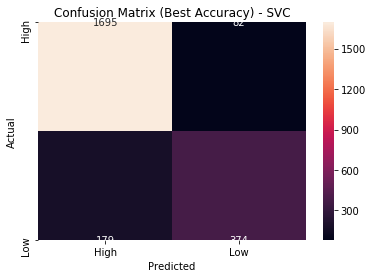

Performing cross-validation for NBC...
Iteration  1
Shape of training data:  (20973, 4873)
Shape of test data:  (2331, 4873)
Iteration  2
Shape of training data:  (20973, 4881)
Shape of test data:  (2331, 4881)
Iteration  3
Shape of training data:  (20973, 4871)
Shape of test data:  (2331, 4871)
Iteration  4
Shape of training data:  (20973, 4846)
Shape of test data:  (2331, 4846)
Iteration  5
Shape of training data:  (20974, 4868)
Shape of test data:  (2330, 4868)
Iteration  6
Shape of training data:  (20974, 4898)
Shape of test data:  (2330, 4898)
Iteration  7
Shape of training data:  (20974, 4855)
Shape of test data:  (2330, 4855)
Iteration  8
Shape of training data:  (20974, 4877)
Shape of test data:  (2330, 4877)
Iteration  9
Shape of training data:  (20974, 4878)
Shape of test data:  (2330, 4878)
Iteration  10
Shape of training data:  (20974, 4886)
Shape of test data:  (2330, 4886)
List of cross-validation accuracies for NBC:  [0.8232518232518232, 0.8301158301158301, 0.84298584298

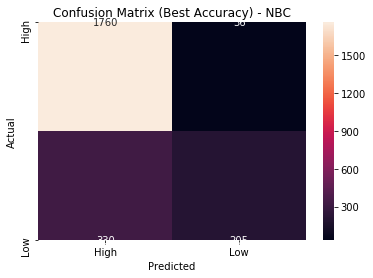

Shape of tfidf matrix for saved SVC Model:  (23304, 5436)
Number of tweets remaining after cleaning:  852
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Review  \
0  "Have been on Actos for almost a year, gained 24 pounds and have swelling in hands and feet and are retaining a lot of water in my thighs.  My sugar levels

In [9]:
def main():
    #### Reading training dataset as dataframe
    df = pd.read_csv("MedReviews.csv", encoding = "ISO-8859-1")
    pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
    
    
    #### Normalizing tweets
    df['normalized_tweet'] = df.Review.apply(normalizer)
    df = df[df['normalized_tweet'].map(len) > 0] # removing rows with normalized tweets of length 0
    print("Printing top 5 rows of dataframe showing original and cleaned tweets....")
    print(df[['Review','normalized_tweet']].head())
    df.drop(['Medicine', 'Condition', 'Review'], axis=1, inplace=True)
    
    
    #### Saving cleaned tweets to csv
    df.to_csv('cleaned_data.csv', encoding='utf-8', index=False)
    
    
    #### Reading cleaned tweets as dataframe
    cleaned_data = pd.read_csv("cleaned_data.csv", encoding = "ISO-8859-1")
    pd.set_option('display.max_colwidth', -1)
    data = cleaned_data.normalized_tweet
    targets = cleaned_data.Rating
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=30, norm='l2', ngram_range=(1,3)) # min_df=30 is a clever way of feature engineering

    SVC_clf = LinearSVC() # SVC Model
    SVC_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test = Cross_validation(data, targets, tfidf, SVC_clf, "SVC") # SVC cross-validation
    c_matrix(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, SVC_clf, "SVC") # SVC confusion matrix

    NBC_clf = MultinomialNB() # NBC Model
    NBC_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test = Cross_validation(data, targets, tfidf, NBC_clf, "NBC") # NBC cross-validation
    c_matrix(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, tfidf, targets, NBC_clf, "NBC") # NBC confusion matrix

    if SVC_mean_accuracy > NBC_mean_accuracy:
        SVC_Save(data, targets, tfidf)
    else:
        NBC_Save(data, targets, tfidf)
    
    deployment()

if __name__ == "__main__":
    main()
